<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter11/adversarial_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_snippets
from torch_snippets import inspect, show, np, torch, nn
from torchvision.models import resnet50
model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.eval()
import requests
from PIL import Image
url = 'https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg'
original_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 61kB 8.2MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=82b083b29ca7f215851c639ca6bd172408728dbae264ecd941c03fe23f1d0c69
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
image_net_classes = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i:j for j,i in image_net_ids.items()}

In [ ]:
from torchvision import transforms as T
from torch.nn import functional as F
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])
def image2tensor(input):
    x = normalize(input.clone().permute(2,0,1)/255.)[None]
    return x
def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1,2,0)*255.).type(torch.uint8)
    return x

In [ ]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f'PREDICTION: `{clss}` @ {prob.item()}')

In [ ]:
from tqdm import trange
losses = []
def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()

In [ ]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [ ]:
for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


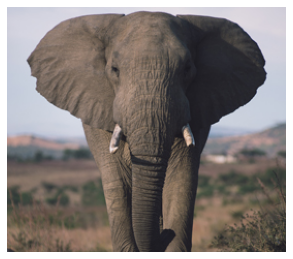

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234400033950806
Tensor	Shape: torch.Size([237, 270, 3])	Min: 17.000	Max: 255.000	Mean: 110.237	dtype: torch.float32


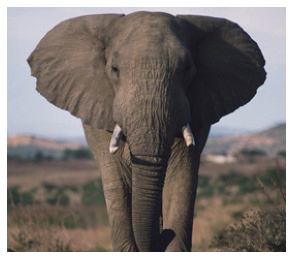

PREDICTION: `lemon` @ 0.9999923706054688
Tensor	Shape: torch.Size([237, 270, 3])	Min: 11.000	Max: 248.000	Mean: 105.229	dtype: torch.uint8


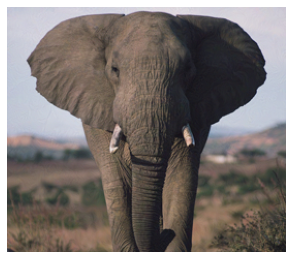

PREDICTION: `comic book` @ 0.9999936819076538
Tensor	Shape: torch.Size([237, 270, 3])	Min: 9.000	Max: 245.000	Mean: 105.236	dtype: torch.uint8


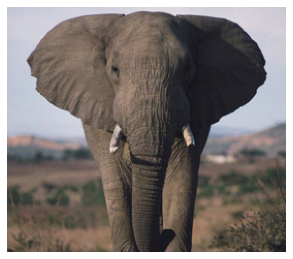

PREDICTION: `sax, saxophone` @ 0.9999990463256836
Tensor	Shape: torch.Size([237, 270, 3])	Min: 11.000	Max: 247.000	Mean: 105.237	dtype: torch.uint8


In [ ]:
for image in [original_image, *modified_images]:
    predict_on_image(image)
    inspect(image)